# Experiments with the concatenated Shor code

In the following, a series of experiments will be performed to investigate the capacity of the concatenated Shor code for fault tolerant quantum computing. The concatenated Shor Code is the 9 qubit Shor Code concatenated with itself yielding $[[9^n, 1, 3^n]]$ quantum error correction codes where $n$ is the level of concatenation and $n=1$ is the usual 9 qubit Shor code. This notebook also serves as a guide for using the ConcatenatedShorQubit and ShorCircuit classes to do your own experiments with the Shor Code.

In [1]:
#Import needed packages
from shor_code_package.shor_code import ConcatenatedShorQubit, ShorCircuit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, ReadoutError, pauli_error)
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

## 1. Error correction capabilities of the concatenated Shor code

The Shor code has code distance $3$ meaning that a Pauli string of weight $3$, meaning $3$ of the Paulies are different from the identity, can take the $|0_L\rangle$ state to the $|1_L\rangle$ state. An example of such a Pauli string is $Z_0\cdot Z_3\cdot Z_6$ which is indeed one of the ways the logical $X$ operator of the Shor code can be expressed. When an error occurs, it will take initial logical state it affects at most a distance $d$ away from a logical state where $d$ is the weight of the Pauli string representing the error. If $d \geq d_\textup{code}/2$, where $d_\textup{code}$ is the code distance, then error correction will see that the shortest distance to a codeword is to a codeword which was not the original state, and error correction will fail. Therefore, a quantum error correction code with code distance $d_\textup{code}$ can reliably correct $(d_\textup{code}-1)/2$ errors.

The above is the worst case scenario. There may however also be errors with much greater weight that are correctable by the code, because the errors in a sense cancel each other out. An example is $X_0\ X_3 \ Y_6Z_7Z_8$ with weight 5. During error correction, $X$ will be applied to qubit 0, 3, and 6, and $Z$ will be applied to qubit 6. Nothing will be done to qubit 7 and 8 since $Z_7Z_8$ is one of the stabilizers of the Shor Code. In total error correction will be succesful.

It is thus clear that one can get lucky that the errors that occur may pair up to lie in the stabilizer group of the Shor code or its concatenations. It seems the Shor code may be able to handle more bit flip errors than phase flip errors. In the following this hypothesis is put to the test.

The noise model will be configured to apply an $X$, $Y$ or $Z$ Pauli with equal probability $p/3$ to each of the physical qubits where $p = d_\textup{code} /(\textup{\# physical qubits})$.

In [2]:
class NoiseModelExperiment:
    def __init__(self, qc, noise_model_generator, noise_model_generator_inputs, shots = 1000, silent = True, method = 'stabilizer'):
        self.noise_model_generator = noise_model_generator
        self.inputs = noise_model_generator_inputs
        self.output = []
        self.aer = AerSimulator(method = method, basis_gates=['x','z','s','sdg','cx','h'])
        self.shots = shots

        #Transpile the circuit for the simulator
        pass_manager = generate_preset_pass_manager(1, self.aer) #Optimization level = 1 or else it won't work.
        self.qc = pass_manager.run(qc)
        self.silent = silent

    def run(self):
        for index, input in enumerate(self.inputs):
            noise_model = self.noise_model_generator(input)
            self.aer.set_option("noise_model", noise_model)
            run = self.aer.run(self.qc, shots = self.shots)
            self.output.append(run.result())
            if not self.silent:
                print(f"Simulation {index} of {len(self.inputs)} done.", end = "\r")
        return self.output

In [ ]:
#The experiment is repeated for each of the Pauli operator eigenbases 
results = []
for experiment in ['X','Y','Z','high_res_x','high_res_z', 'high_res_y', 'zoom_x', 'zoom_z', 'zoom_y']:
    n = 1
    if experiment == 'high_res_x':
        inputs = [(px, 0, 0) for px in np.linspace(0, 1, 300)]
    elif experiment == 'high_res_z':
        inputs = [(0, pz, 0) for pz in np.linspace(0, 1, 300)]
    elif experiment == 'high_res_y':
        inputs = [(0, 0, py) for py in np.linspace(0, 1, 300)]
    elif experiment == 'zoom_x':
        inputs = [(px, 0, 0) for px in np.linspace(0, 0.05, 100)]
    elif experiment == 'zoom_z':
        inputs = [(0, pz, 0) for pz in np.linspace(0, 0.05, 100)]
    elif experiment == 'zoom_y':
        inputs = [(0, 0, py) for py in np.linspace(0, 0.05, 100)]
    else:
        inputs = [(px, pz, 0) for px in np.linspace(0, 0.33, 15) for pz in np.linspace(0, 0.33, 15)]
    shots = 2e3
    num_qubits = 9**n

    #Set up circuit
    shor_circuit = ShorCircuit([n])

    #Convert to desired basis
    if experiment == "X":
        shor_circuit.h(0)
    elif experiment not in ['Z']:
        shor_circuit.h(0)
        shor_circuit.s(0)

    #Add circuit for introducing error
    shor_circuit._circuit.add_register(QuantumRegister(1))
    error_circuit = QuantumCircuit(num_qubits + 2)
    for q in range(num_qubits):
        #These are the gates introducing error
        error_circuit.cx(num_qubits+1, q)
    shor_circuit._circuit.compose(error_circuit, inplace=True)

    #Correct the error
    shor_circuit.error_correct(0)

    #Transform back to Z basis
    if experiment == "X":
        shor_circuit.h(0)
    elif experiment not in ['Z']:
        shor_circuit.sdg(0)
        shor_circuit.h(0)

    #Measure
    output_register = ClassicalRegister(1)
    shor_circuit.add_register(output_register)
    shor_circuit.measure(0, output_register)

    #Define noise model
    def noise_model_generator(input):
        #Set up noise model
        px, pz, py = input
        x_error = pauli_error([('II', 1-(px)),('XI', px)]) #X I = Target Control
        z_error = pauli_error([('II', 1-(pz)),('ZI', pz)])
        y_error = pauli_error([('II', 1-(py)),('YI', py)])
        error = x_error.compose(z_error.compose(y_error))
        noise_model = NoiseModel()
        for q in range(num_qubits):
            noise_model.add_quantum_error(error, ['cx'], [num_qubits+1, q]) #The error is applied after applying an entangling gate from an unused ancilla.
        return noise_model

    #Simulate
    noise_model_experiment = NoiseModelExperiment(shor_circuit.get_circuit(), noise_model_generator, inputs, shots=shots, silent = False)
    result = noise_model_experiment.run()
    results.append(result)



In [54]:
#Post process simulation results
post_processed = []
for result in results[:3]:
    fidelities = [sum([experiment.get_counts()[key] for key in experiment.get_counts().keys() if key.startswith('0')])/shots for experiment in result]
    fidelities_grid = np.reshape(fidelities, (15,15))
    post_processed.append(fidelities_grid)

for result in results[3:]:
    fidelities = [sum([experiment.get_counts()[key] for key in experiment.get_counts().keys() if key.startswith('0')])/shots for experiment in result]
    post_processed.append(fidelities)

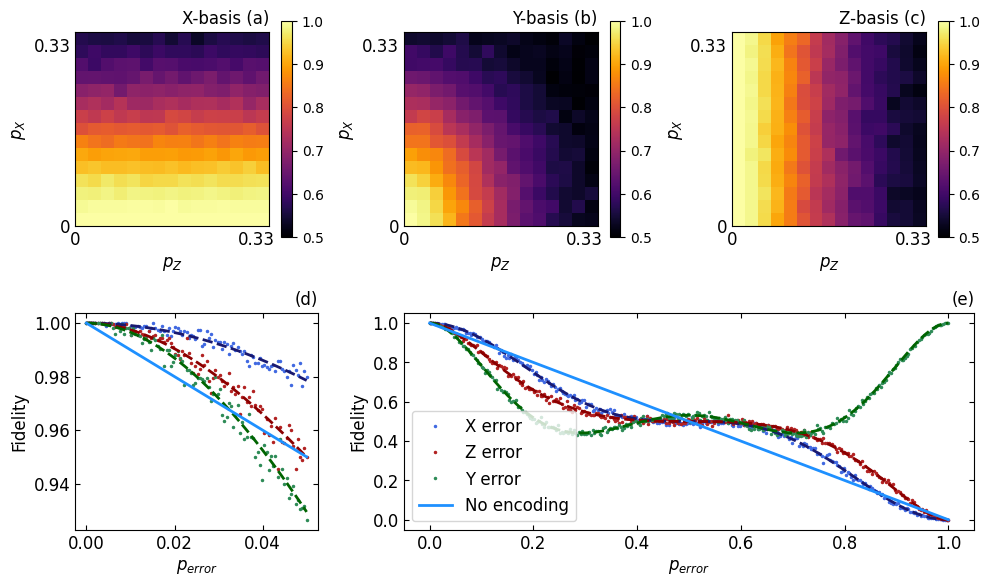

In [144]:
plt.figure(figsize=(10,6))


rows_cols = (2,6)
ax21 = plt.subplot2grid(rows_cols, (1,0), colspan=2)
ax22 = plt.subplot2grid(rows_cols, (1,2), colspan=4)
ax11 = plt.subplot2grid(rows_cols, (0,0), colspan=2)
ax12 = plt.subplot2grid(rows_cols, (0,2), colspan=2)
ax13 = plt.subplot2grid(rows_cols, (0,4), colspan=2)
axs = [ax21, ax22, ax11, ax12, ax13]

for ax in axs:
    ax.tick_params(direction='in', left=True, right=True, top=True, bottom=True)

#Plot data
im1 = axs[2].imshow(post_processed[0], cmap='inferno', origin="lower", vmin=0.5)
plt.colorbar(im1)

im2 = axs[3].imshow(post_processed[1], cmap='inferno', origin="lower", vmin=0.5)
plt.colorbar(im2)

im3=axs[4].imshow(post_processed[2], cmap='inferno', origin="lower", vmin=0.5)
plt.colorbar(im3)


#Plot theoretical curves
ps = np.linspace(0,1,300)
p3x = lambda p: (1-p)**3 + 3*p*(1-p)**2
p9x = lambda p: p3x(p)**3 + 3*p3x(p)*(1-p3x(p))**2
p3z = lambda p: (1-p)**3 + 3*p**2*(1-p)
p9z = lambda p: p3z(p)**3 + 3*p3z(p)**2*(1-p3z(p))
p_y = lambda p: (1-p)**9 + 9*p*(1-p)**8 + 126*p**4*(1-p)**5 + 126*p**5*(1-p)**4 + 9*(1-p)*p**8 + p**9 

ax22.plot(ps,post_processed[3], label='X error', color='royalblue', marker='.', markersize=3, linestyle='none')
ax22.plot(ps,post_processed[4], label='Z error', color='firebrick', marker='.', markersize=3, linestyle='none')
ax22.plot(ps,post_processed[5], label='Y error', color='seagreen', marker='.', markersize=3, linestyle='none')

ax22.plot(ps,1- ps, label='No encoding', linestyle='-', color='dodgerblue', zorder=5000, lw=2)
ax22.plot(ps,p9x(ps), color='midnightblue', linestyle='--', lw=2)
ax22.plot(ps,p9z(ps), color='darkred', linestyle='--',lw=2)
ax22.plot(ps, p_y(ps), color='darkgreen', linestyle='--',lw=2)

ps = np.linspace(0,0.05,100)
ax21.plot(ps,post_processed[6], label='X error', color='royalblue', marker='.', markersize=3, linestyle='none')
ax21.plot(ps,post_processed[7], label='Z error', color='firebrick', marker='.', markersize=3, linestyle='none')
ax21.plot(ps,post_processed[8], label='Y error', color='seagreen', marker='.', markersize=3, linestyle='none')

ax21.plot(ps,1- ps, label='No encoding', linestyle='-', color='dodgerblue', zorder=5000, lw=2)
ax21.plot(ps, p9x(ps), color='midnightblue', linestyle='--', zorder=1000, lw=2)
ax21.plot(ps, p9z(ps), color='darkred', linestyle='--',zorder=1000, lw=2)
ax21.plot(ps, p_y(ps), color='darkgreen', linestyle='--',zorder=1000, lw=2)

for ax in axs[2:]:
    ax.set_xlabel("$p_Z$", size=12)
    ax.set_ylabel("$p_X$", size=12)
    ax.xaxis.set_major_locator(ticker.FixedLocator([-0.5, 13.5]))
    ax.yaxis.set_major_locator(ticker.FixedLocator([-0.5, 13.5]))
    ax.set_xticklabels(['0','0.33'], size=12)
    ax.set_yticklabels(['0','0.33'], size=12)
    ax.tick_params(size=0)
    
axs[2].set_title("X-basis (a)", loc="right", size=12)
axs[3].set_title("Y-basis (b)", loc="right", size=12)
axs[4].set_title("Z-basis (c)", loc="right", size=12)

for ax in [ax21, ax22]:
    ax.set_xlabel('$p_{error}$', size=12)
    ax.set_ylabel('Fidelity',size=12)
    ax.tick_params(labelsize=12)
ax21.set_title("(d)", loc="right", size=12)
ax22.set_title("(e)", loc="right", size=12)
ax22.legend(fontsize=12)
plt.tight_layout()
plt.savefig("pauli_errors.svg")

Lets now investigate how X, Y, and Z errors affect other bases than their eigenbases.


In [136]:
thetas = np.linspace(0,2*np.pi,36)
ps = np.zeros(10)#np.linspace(0,0.33,10)

results_theta = []
for pauli in ['X']:#,'Y','Z']:
    inputs = [(0,p,0) for p in ps]
    for theta in thetas:
        print(theta)
        n = 1
        shots = 2e3
        num_qubits = 9**n

        #Set up circuit
        shor_circuit = ShorCircuit([n], auto_encode=False)
        qc = QuantumCircuit(9+1)
        qc.h(0)
        qc.rz(theta,0)
        shor_circuit._circuit.compose(qc, front=True, inplace=True)

        #Add circuit for introducing error
        shor_circuit._circuit.add_register(QuantumRegister(1))
        error_circuit = QuantumCircuit(num_qubits + 2)
        for q in range(num_qubits):
            #These are the gates introducing error
            error_circuit.cx(num_qubits+1, q)
        shor_circuit._circuit.compose(error_circuit, inplace=True)

        #Correct the error
        shor_circuit.error_correct(0)
        shor_circuit.decoder(0)
        shor_circuit._circuit.compose(qc.inverse(), inplace=True)

        #Measure
        output_register = ClassicalRegister(1)
        shor_circuit.add_register(output_register)
        shor_circuit.measure(0, output_register)

        #Define noise model
        def noise_model_generator(input):
            #Set up noise model
            px, pz, py = input
            x_error = pauli_error([('II', 1-(px)),('XI', px)]) #X I = Target Control
            z_error = pauli_error([('II', 1-(pz)),('ZI', pz)])
            y_error = pauli_error([('II', 1-(py)),('YI', py)])
            error = x_error.compose(z_error.compose(y_error))
            noise_model = NoiseModel()
            for q in range(num_qubits):
                noise_model.add_quantum_error(error, ['cx'], [num_qubits+1, q]) #The error is applied after applying an entangling gate from an unused ancilla.
            return noise_model

        #Simulate
        noise_model_experiment = NoiseModelExperiment(shor_circuit.get_circuit(), noise_model_generator, inputs, shots=shots, silent = False, method='automatic')
        result = noise_model_experiment.run()
        results_theta.append(result)

0.0
0.17951958020513104done.
0.35903916041026207done.
0.5385587406153931 done.
0.7180783208205241 done.
0.8975979010256552 done.
1.0771174812307862 done.
1.2566370614359172 done.
1.4361566416410483 done.
1.6156762218461793 done.
1.7951958020513104 done.
1.9747153822564414 done.
2.1542349624615724 done.
2.3337545426667035 done.
2.5132741228718345 done.
2.6927937030769655 done.
2.8723132832820966 done.
3.0518328634872276 done.
3.2313524436923586 done.
3.4108720238974897 done.
3.5903916041026207 done.
3.7699111843077517 done.
3.9494307645128828 done.
4.1289503447180140 done.
4.3084699249231450 done.
4.4879895051282760 done.
4.6675090853334070 done.
4.8470286655385380 done.
5.0265482457436690 done.
5.2060678259488 10 done.
5.3855874061539310 done.
5.5651069863590620 done.
5.7446265665641930 done.
5.9241461467693240 done.
6.1036657269744550 done.
6.2831853071795860 done.


In [137]:
post_processed_theta = []
for result in results_theta:
    fidelities = [sum([experiment.get_counts()[key] for key in experiment.get_counts().keys() if key.startswith('0')])/shots for experiment in result]
    post_processed_theta.append(fidelities)

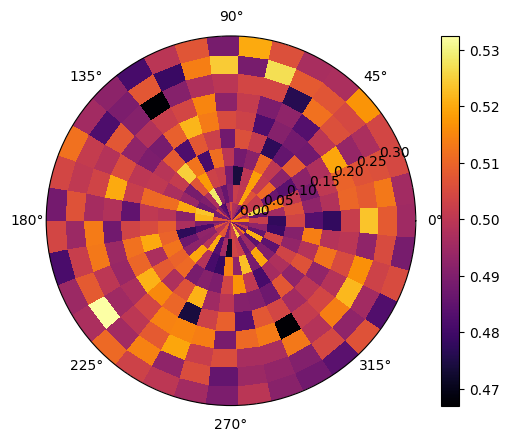

In [141]:
from mpl_toolkits.mplot3d import Axes3D


thetas = np.linspace(0,2*np.pi,36)
ps = np.linspace(0,0.33,10)

fig = plt.figure()
ax = Axes3D(fig)

r, th = np.meshgrid(ps, thetas)

plt.subplot(projection="polar")

plt.pcolormesh(th, r, np.reshape(post_processed_theta, (36,10)), cmap='inferno')
plt.colorbar()

plt.grid()

plt.show()

# Error correction and logical operations in the presence of imperfect gates and measurements

In a real application, gates and measurements are not ideal. Therefore a very simple noise model is next considered. The noise model will be characterised by a number, $0\leq p \leq 1$, and the errors of different circuit components are defined as follows

- Single-qubit gate: $p$
- CNOT gate: $2p$
- Probability of erroneous measurement: $10p$.

The probability is capped at 1, and the error introduced in each case is one of the Pauli errors. For the CNOT gate, both target and control will be affected by the error. For many quantum computers the gate fidelity is reported to be above $99\%$, so $p$ will be investigated from about $1\%$ and smaller.

To quantify the performance of the (concatenated) Shor code, two circuits are being considered. The first one initialises the input state to the logical $|0\rangle$, and simply performs error correction. Then the stabiliser is saved to determine whether error correction was succesful. The second circuit will initialise the input state to $|+\rangle$, perform a logical Hadamard gate, and then read out the stabiliser to determine if it was correctly transformed to $|0\rangle$.




https://www.deic.dk/sites/default/files/2025-11/Quantum_Computing_Guide_october_2025.pdf

In [64]:
#Define the noise model
def noise_model_generator(p_gate, p_cnot, p_meas):
    error_single_qubit_gate = pauli_error([('I', 1-p_gate), ('X', p_gate/3), ('Y', p_gate/3), ('Z', p_gate/3)])
    error_cnot = pauli_error([('II', 1-p_cnot), ('XX', p_cnot/3), ('YY', p_cnot/3), ('ZZ', p_cnot/3)])
    error_readout = ReadoutError([[1-p_meas, p_meas],[1-p_meas, p_meas]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_single_qubit_gate, ['h','x','y','z','s','sdg'])
    noise_model.add_all_qubit_quantum_error(error_cnot, ['cx'])
    noise_model.add_all_qubit_readout_error(error_readout)

    return noise_model

#Define method for getting input stabiliser for a circuit
def get_stabilizer(qc):
    aer = AerSimulator(method='stabilizer')
    qc.save_stabilizer(label='s')
    return aer.run(qc, shots = 1).result().data()['s']

In [ ]:
#Simulate only using measurement error
ps_variable_measurement_error = np.linspace(0.00001,0.10,10)
ps_fixed_measurement_error = np.linspace(0.00001,0.01,15)
ns = [1,2]
num_measurements = [1,3,5]
noise_models = {"variable_measurement": (ps_variable_measurement_error, lambda p: noise_model_generator(0,0,p)), "fixed_measurement": (ps_fixed_measurement_error, lambda p: noise_model_generator(p,p,0.05))}
results = dict()
inputs = dict()
shots = 1e3
i = 0
for n in ns:
    for nm in num_measurements:
        sc = ShorCircuit([n], num_measurements_in_error_correction=nm, auto_encode=False)
        classical_register = ClassicalRegister(2000)
        sc.add_register(classical_register)
        
        encoder = ConcatenatedShorQubit(n).encoder()
        encoder.add_register(QuantumRegister(1)) #Add ancilla
        input_stabilizer = get_stabilizer(encoder)

        sc.set_stabilizer(input_stabilizer)
        sc.error_correct(0)
        sc.save_stabilizer(label = 's', pershot = True)
        qc = sc.get_circuit(classical_register=classical_register)

        for key, noise_model in noise_models.items():
            if (noise_model[0] == "variable_measurement" or num_measurements == 3) and n > 1 :
                continue #Skip these data points.
            print(i)
            i += 1
            experiment = NoiseModelExperiment(qc, noise_model[1], noise_model[0], shots=shots, silent=False, method='stabilizer')
            inputs[f"{key},{n},{nm}"] = input_stabilizer
            results[f"{key},{n},{nm}"] = experiment.run()
        


0
1imulation 9 of 10 done.
2imulation 14 of 15 done.
3imulation 9 of 10 done.
4imulation 14 of 15 done.
5imulation 9 of 10 done.


In [100]:
#Post process
post_processed = dict()
for key, value in results.items():
    print(key)
    fidelities = [sum([s.equiv(inputs[key]) for s in res.data()['s']])/shots for res in value]
    post_processed[key] = fidelities

post_processed

variable_measurement,1,1
fixed_measurement,1,1
variable_measurement,1,3
fixed_measurement,1,3
variable_measurement,1,5
fixed_measurement,1,5


{'variable_measurement,1,1': [0.999,
  0.905,
  0.832,
  0.758,
  0.668,
  0.633,
  0.58,
  0.515,
  0.483,
  0.423],
 'fixed_measurement,1,1': [0.651,
  0.655,
  0.615,
  0.599,
  0.568,
  0.579,
  0.576,
  0.547,
  0.505,
  0.525,
  0.529,
  0.475,
  0.454,
  0.426,
  0.474],
 'variable_measurement,1,3': [1.0,
  0.994,
  0.992,
  0.974,
  0.95,
  0.946,
  0.89,
  0.882,
  0.832,
  0.799],
 'fixed_measurement,1,3': [0.946,
  0.895,
  0.839,
  0.788,
  0.715,
  0.712,
  0.669,
  0.656,
  0.596,
  0.582,
  0.519,
  0.51,
  0.462,
  0.459,
  0.447],
 'variable_measurement,1,5': [1.0,
  1.0,
  0.998,
  0.997,
  0.997,
  0.982,
  0.986,
  0.966,
  0.96,
  0.923],
 'fixed_measurement,1,5': [0.987,
  0.91,
  0.831,
  0.783,
  0.702,
  0.66,
  0.626,
  0.571,
  0.526,
  0.468,
  0.421,
  0.423,
  0.365,
  0.325,
  0.304]}

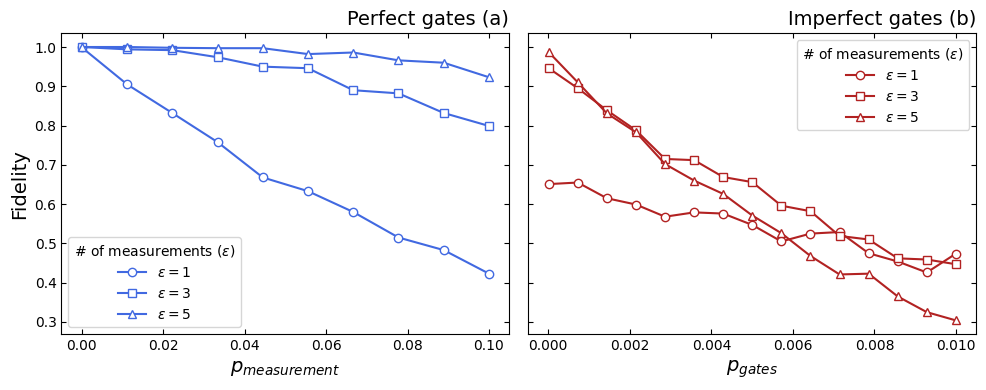

In [101]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1, ax2 = axs

#Plot
ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,1,1"], marker='o', color ='royalblue', markerfacecolor='w', label = r"$\varepsilon=1$")
ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,1,3"], marker='s', color ='royalblue', markerfacecolor='w', label = r"$\varepsilon=3$")
ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,1,5"], marker='^', color ='royalblue', markerfacecolor='w', label = r"$\varepsilon=5$")
#ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,1,7"], marker='D', color ='royalblue', markerfacecolor='w')
#ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,2,1"], marker='o', color ='forestgreen', markerfacecolor='w', label = "")
#ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,2,3"], marker='s', color ='forestgreen', markerfacecolor='w')
#ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,2,5"], marker='^', color ='forestgreen', markerfacecolor='w')
#ax1.plot(ps_variable_measurement_error, post_processed["variable_measurement,2,7"], marker='D', color ='forestgreen', markerfacecolor='w')

ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,1,1"], marker='o', color ='firebrick', markerfacecolor='w', label = r"$\varepsilon=1$")
ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,1,3"], marker='s', color ='firebrick', markerfacecolor='w', label = r"$\varepsilon=3$")
ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,1,5"], marker='^', color ='firebrick', markerfacecolor='w', label = r"$\varepsilon=5$")
#ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,1,7"], marker='D', color ='firebrick', markerfacecolor='w')
#ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,2,1"], marker='o', color ='cornflowerblue', markerfacecolor='w')
#ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,2,3"], marker='s', color ='cornflowerblue', markerfacecolor='w')
#ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,2,5"], marker='^', color ='cornflowerblue', markerfacecolor='w')
#ax2.plot(ps_fixed_measurement_error, post_processed["fixed_measurement,2,7"], marker='D', color ='cornflowerblue', markerfacecolor='w')

#Style
for ax in axs:
    ax.tick_params(direction='in', left=True, right=True, top=True, bottom=True)

ax1.set_xlabel("$p_{measurement}$", size = 14)
ax1.set_ylabel("Fidelity", size = 14)
ax1.set_title("Perfect gates (a)", size = 14, loc="right")

ax2.set_xlabel("$p_{gates}$", size = 14)
#ax2.set_ylabel("Fidelity", size = 14)
ax2.set_title("Imperfect gates (b)", size = 14, loc="right")

ax1.legend(title=r"# of measurements ($\varepsilon$)")
ax2.legend(title=r"# of measurements ($\varepsilon$)")

#Save
plt.tight_layout()
plt.savefig('measuerements1.svg')


#

# Read out error experiments

When reading out qubits there is a probability that the wrong outcome is obtained. To combat this, measurements can be conducted several times and a majority vote between the measurements determine the final outcome. If there is a high risk of readout error, syndrome measurement will fail leading to erroneous corrections made to the logical states. In the following, a simple encoding, 